## Developed by Jonathan Ojeda 26/1/2021 QAAFI UQ

_Code functionalities:_
* Import apsim classic files and compare OBS vs PRE data
* Read several files from a folder and merge them in a single pandas dataframe
* Create scatter plots and add error bars

In [27]:
#import libraries
import random as rd
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
import cartopy.io.shapereader as shpreader
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [28]:
#Tool to minimize code and see only figures
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

## Read data from APSIM and format the dataset to be plotted

In [291]:
filelist = glob.glob(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\APSIMfiles\*HarvestReport.out')
frame = pd.DataFrame()
list = []

for file in filelist:
    df = pd.read_csv(file)
    df.drop(df.index[[0,2]])
    df[['date','year','day','DaysAfterSowing','biomass','stage','StageName','TotalTT()',
        'Title','RainIn','mint_avg','RadiationIn','N_stress_expan','sw_stress_expan','maxt_avg','tp_stress']] = df['ApsimVersion = 7.10 r4210'].str.split(n=16, expand=True)
    a = df.drop(['ApsimVersion = 7.10 r4210'], axis=1)
    b = a.drop(df.index[[0,1,2]])
    #Create categories
    b['location'] = b['Title'].str.slice(0,2)
    b['state'] = b['Title'].str.slice(3,5)
    b['cultivar'] = b['Title'].str.slice(6,8)
    b['nitrogen'] = b['Title'].str.slice(9,13)
    b['year2'] = b['Title'].str.slice(14,19)
    #Change dtype from string to float
    b["day"] = b["day"].astype(str).astype(float)
    b["DaysAfterSowing"] = b["DaysAfterSowing"].astype(str).astype(float)
    b["biomass"] = b["biomass"].astype(str).astype(float)
    b["stage"] = b["stage"].astype(str).astype(float)
    b["TotalTT()"] = b["TotalTT()"].astype(str).astype(float)
    b["RainIn"] = b["RainIn"].astype(str).astype(float)
    b["mint_avg"] = b["mint_avg"].astype(str).astype(float)
    b["RadiationIn"] = b["RadiationIn"].astype(str).astype(float)
    b["N_stress_expan"] = b["N_stress_expan"].astype(str).astype(float)
    b["sw_stress_expan"] = b["sw_stress_expan"].astype(str).astype(float)
    b["maxt_avg"] = b["maxt_avg"].astype(str).astype(float)
    b["tp_stress"] = b["tp_stress"].astype(str).astype(float)
    b["TempIn"] = (b["maxt_avg"] + b["mint_avg"])/2
    #Rename
    b.rename(columns={'biomass':'sim_biomass'}, inplace=True)
    #Create new categories
    b["name"] = b["location"] + "_" + b["state"] + "_" + b["cultivar"] + "_" + b["nitrogen"] + "_" + b["year"]  + "_" + b["year2"] 
    b["env"] = b["location"] + "-" + b["state"]
    b["envyear"] = b["env"] + "-" + b["year"]
    
    list.append(b)
    
all_sim = pd.concat(list)

#read observed data
obs = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\APSIMfiles\observed.csv')
obs['year'] = obs['year'].astype(object)
obs.rename(columns={'biomass':'obs_biomass'}, inplace=True)

#merge obs and pre data
df000 = pd.merge(all_sim, obs, on=["name"], how="inner")
df00=df000.drop(['year_x','location_x','cultivar_x','state_x','nitrogen_x','year2_x','env_x'],axis=1)
df00.rename(columns={'year_y':'year','location_y':'location','cultivar_y':'cultivar','state_y':'state','nitrogen_y':'nitrogen','year2_y':'year2',
                    'env_y':'env'}, inplace=True)
df00['delta'] = df00['obs_biomass']-df00['sim_biomass']

#clean some data with suspicious deviations between reps and data from other sources than SunGrant
#df00b = df00.loc[df00.env != 'We-TX']
df00c = df00.loc[df00.envyear != 'CC-TX-2008']
#df00d = df00c.drop(df00c.index[[130, 145]])
a = ['MS_Ra_ES_2012_N200_Y_ALL','MS_Ra_M8_2010_N200_Y_ALL','TX_We_4E_2009_N000_Y2009','TX_We_4E_2009_N280_Y2009',
    'MS_Ra_ES_2011_N200_Y_ALL', 'MS_Ra_GN_2011_N200_Y_ALL']
df = df00c[~df00c['name'].isin(a)]

#Getting 15% off from Wa-NC biomass due to was harvested from 15 cm 
df.loc[df['env'] == 'Wa-NC', 'sim_biomass2'] = df['sim_biomass']*0.85
df.loc[df['env'] != 'Wa-NC', 'sim_biomass2'] = df['sim_biomass']

#read Purdue data
purdue = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\purdue.csv')
BuTX = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\BuTX.csv')

## Clean outliers and remove some columns

In [298]:
df['sim_biomass3'] = df['sim_biomass2']/1000
df['obs_biomass3'] = df['obs_biomass']/1000
df['biomassError3'] = df['biomassError']/1000
final0 = df.drop(df[(df['state'] == 'IN') & (df['year2'] == 'Y2015')].index)
final00 = final0.loc[final0.name != 'We_TX_4E_N000_2009_Y2009']
final00a = final00.loc[final00.name != 'Ra_MS_ES_N200_2011_Y_ALL']
final00b = final00a.loc[final00a.name != 'We_TX_4E_N280_2009_Y2009']
final00c = final00b.loc[final00b.name != 'Ra_MS_M8_N200_2010_Y_ALL']

final000 = final00c.drop(['date', 'day', 'DaysAfterSowing', 'sim_biomass', 'stage', 'StageName',
       'TotalTT()', 'Title',
       'obs_biomass', 'biomassError', 'type',
       'delta', 'sim_biomass2','envyear','cultivar2'],axis=1)
final = pd.concat([final000, BuTX])
final['Dev'] = final['sim_biomass3'] - final['obs_biomass3']

## Plot Pre vs Ovs

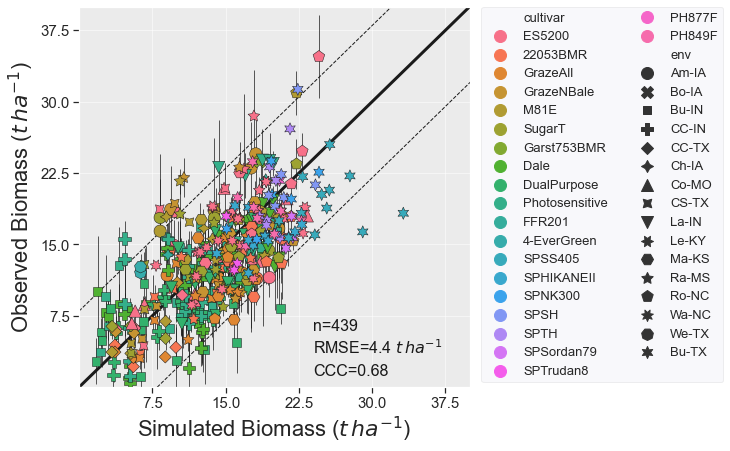

In [172]:
#plot
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(7,7))

ax=plt.subplot(1, 1, 1)
xmax=40
ymax=40
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(final['sim_biomass3'], final['obs_biomass3'], yerr = final['biomassError3'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass3", y="obs_biomass3",hue='cultivar', style='env', alpha=1, data=final, linewidth=0.5,**kwargs, s=150,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=13),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=2,framealpha=0.3,markerscale=2)
plt.ylabel('Observed Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Simulated Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(final.obs_biomass3.values)
y_o= Obs.tolist()
Pre = pd.Series(final.sim_biomass3.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
#plt.text(xmax*0.02, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.6, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.6, ymax*0.09,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.6, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.6, hspace=0.25)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\Figs\val.png', dpi=300,bbox_inches='tight')
hide_toggle()

In [8]:
A = purdue.loc[(purdue.env == 'Bu-TX')]
A.cultivar.unique()

array(['SPSS405', 'SPHIKANEII', 'SPNK300', 'SPSH', 'SPTH', 'SPSordan79',
       'SPTrudan8', 'PH877F', 'PH849F'], dtype=object)

In [9]:
final.loc[(final.obs_biomass3>34.7)]

,name,year,location,cultivar,nitrogen,env,state,year2,sim_biomass3,obs_biomass3,biomassError3,biomassError
366,Ro_NC_ES_N200_2009_Y_ALL,2009,Ro,ES5200,N200,Ro-NC,NC,Y_ALL,24.5571,34.7447,4.4015,NaN


In [10]:
final.loc[(final.sim_biomass3>22.5)&(final.obs_biomass3>32)]

,name,year,location,cultivar,nitrogen,env,state,year2,sim_biomass3,obs_biomass3,biomassError3,biomassError
366,Ro_NC_ES_N200_2009_Y_ALL,2009,Ro,ES5200,N200,Ro-NC,NC,Y_ALL,24.5571,34.7447,4.4015,NaN


In [12]:
stat_mean = final.groupby(['cultivar'],as_index=False).mean()
stat_sd = final.groupby(['cultivar'],as_index=False).std()
stat_c = final.groupby(['cultivar'],as_index=False).count()
stat_mean.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatMean.csv')
stat_sd.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatSD.csv')
stat_c.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatc.csv')

In [13]:
#df.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\df_final.csv')

## Read in season data from West Lafayette

In [173]:
WL = purdue[purdue['env'] == 'WL-IN']
#all_data = final[final['env'] != 'WL-IN']
#all_data = all_data.loc[~((all_data['env']=='Bu-Tx') | (all_data['cultivar']=='SPSS405'))]

WL['obs_biomass2'] = WL['obs_biomass']/1000
WL['sim_biomass2'] = WL['sim_biomass']/1000
WL['error_biomass2'] = WL['error_biomass']/1000
#all_data['obs_biomass2'] = all_data['obs_biomass']/1000
#all_data['sim_biomass2'] = all_data['sim_biomass']/1000
#all_data['biomassError2'] = all_data['biomassError']/1000

<ipython-input-173-b5d7563b1438>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WL['obs_biomass2'] = WL['obs_biomass']/1000
<ipython-input-173-b5d7563b1438>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WL['sim_biomass2'] = WL['sim_biomass']/1000
<ipython-input-173-b5d7563b1438>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

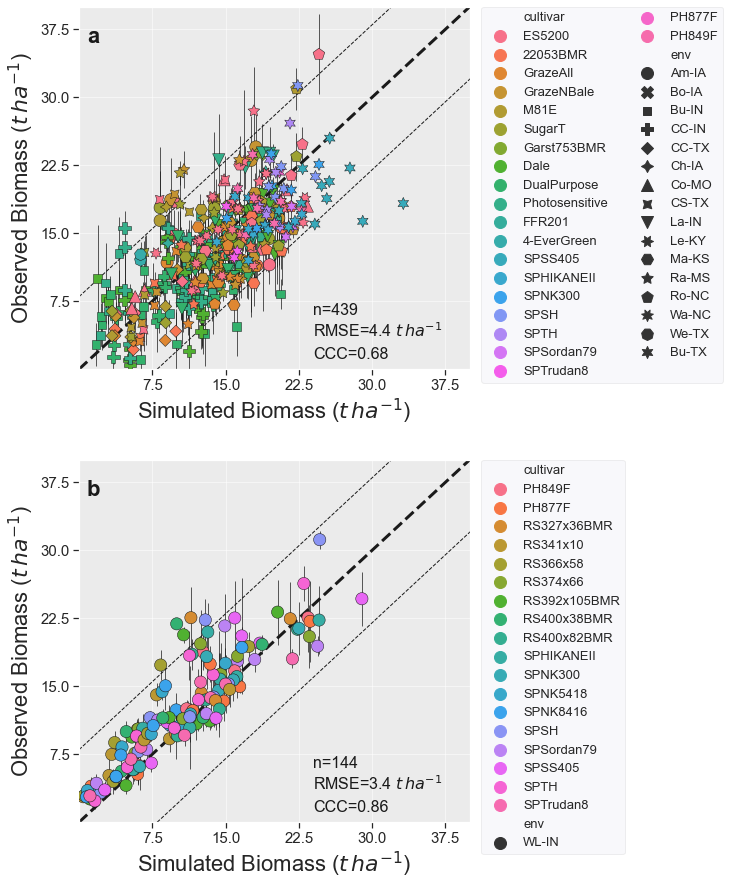

In [174]:
#plot
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(7,15))

ax=plt.subplot(2, 1, 1)
xmax=40
ymax=40
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"--",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(final['sim_biomass3'], final['obs_biomass3'], yerr = final['biomassError3'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass3", y="obs_biomass3",hue='cultivar', style='env', alpha=1, data=final, linewidth=0.5,**kwargs, s=150,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=13),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=2,framealpha=0.3,markerscale=2)
plt.ylabel('Observed Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Simulated Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(final.obs_biomass3.values)
y_o= Obs.tolist()
Pre = pd.Series(final.sim_biomass3.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.02, ymax*0.9,'a',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.6, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.6, ymax*0.09,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.6, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')
###################################################################

ax=plt.subplot(2, 1, 2)
xmax=40
ymax=40
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"--",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(WL['sim_biomass2'], WL['obs_biomass2'], yerr = WL['error_biomass2'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass2", y="obs_biomass2",hue='cultivar', style='env', alpha=1, data=WL, linewidth=0.5,**kwargs, s=150,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=13),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('Observed Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Simulated Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(WL.obs_biomass2.values)
y_o= Obs.tolist()
Pre = pd.Series(WL.sim_biomass2.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.02, ymax*0.9,'b',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.6, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.6, ymax*0.09,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.6, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.6, hspace=0.25)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\val2.png', dpi=300,bbox_inches='tight')
hide_toggle()

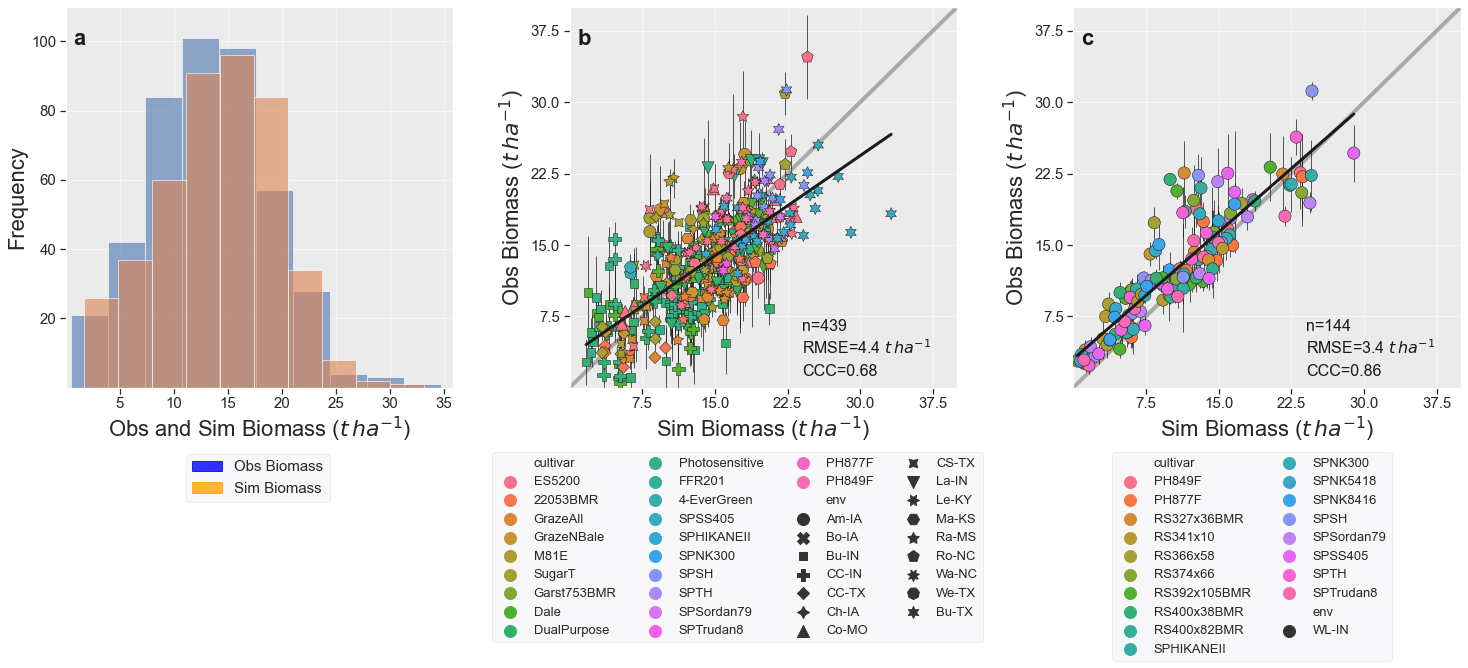

In [177]:
#plot
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(25,7))

################################################################
ax=plt.subplot(1, 3, 1)
xmax=35.9
ymax=109.9
xmax20=xmax*0.2 
final.obs_biomass3.plot.hist(alpha=0.6)
final.sim_biomass3.plot.hist(alpha=0.6)

# Formatting graph and background
plt.ylabel('Frequency', fontsize =22)
plt.xlabel('Obs and Sim Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Plot statistical values
plt.text(xmax*0.02, ymax*0.9,'a',fontsize=22,color='k',weight='bold')
#plt.text(xmax*0.6, ymax*0.95,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
#plt.text(xmax*0.6, ymax*0.89,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=16,color='k')
#plt.text(xmax*0.6, ymax*0.83,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

blue_patch = mpatches.Patch(color='blue',alpha=.8,label='Obs Biomass')
orange_patch = mpatches.Patch(color='orange',alpha=.8,label='Sim Biomass')

leg=plt.legend(handles=[blue_patch,orange_patch],fontsize=15, loc=4, ncol=1, bbox_to_anchor=[0.7, -0.32],framealpha=0.3,markerscale=2)   
#leg.get_frame().set_linewidth(0.0)

#################################################################
ax=plt.subplot(1, 3, 2)
xmax=40
ymax=40
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"-",color="darkgrey", linewidth=4,zorder=1)
#plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
#plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(final['sim_biomass3'], final['obs_biomass3'], yerr = final['biomassError3'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass3", y="obs_biomass3",hue='cultivar', style='env', alpha=1, data=final, linewidth=0.5,**kwargs, s=150,zorder=3)
sns.regplot(x="sim_biomass3", y="obs_biomass3", data=final, ci=None, color='k', scatter=False, line_kws={'linewidth':3, "zorder":4})

# Formatting graph and background
plt.legend(prop=dict(size=13),bbox_to_anchor=(-0.2, -0.17), loc=2, borderaxespad=0., ncol=4,framealpha=0.3,markerscale=2)
plt.ylabel('Obs Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Sim Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(final.obs_biomass3.values)
y_o= Obs.tolist()
Pre = pd.Series(final.sim_biomass3.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.02, ymax*0.9,'b',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.6, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.6, ymax*0.09,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.6, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

###################################################################
ax=plt.subplot(1, 3, 3)
xmax=40
ymax=40
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"-",color="darkgrey", linewidth=4,zorder=1)
#plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
#plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(WL['sim_biomass2'], WL['obs_biomass2'], yerr = WL['error_biomass2'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass2", y="obs_biomass2",hue='cultivar', style='env', alpha=1, data=WL, linewidth=0.5,**kwargs, s=150,zorder=3)
sns.regplot(x="sim_biomass2", y="obs_biomass2", data=WL, ci=None, color='k', scatter=False, line_kws={'linewidth':3, "zorder":4})

# Formatting graph and background
plt.legend(prop=dict(size=13),bbox_to_anchor=(0.1, -0.17), loc=2, borderaxespad=0., ncol=2,framealpha=0.3,markerscale=2)
plt.ylabel('Obs Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Sim Biomass ($t\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(WL.obs_biomass2.values)
y_o= Obs.tolist()
Pre = pd.Series(WL.sim_biomass2.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.02, ymax*0.9,'c',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.6, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.6, ymax*0.09,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.6, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.3, hspace=0.25)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\val2.png', dpi=300,bbox_inches='tight')
hide_toggle()

## Plot scatter plots for Pre vs Obs by environment and cultivar

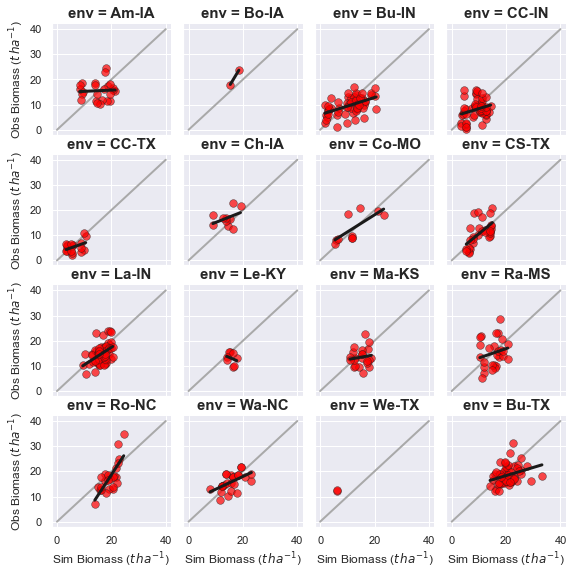

In [178]:
kwargs  =   {'edgecolor':"k"}
sns.set(font_scale=1)
g = sns.FacetGrid(final, col="env", col_wrap=4, height=2)
g.map(sns.scatterplot, "sim_biomass3", "obs_biomass3", alpha=0.7, linewidth=0.5,**kwargs, s=60,zorder=2, color='red')
g.map(sns.regplot, "sim_biomass3", "obs_biomass3", ci=None, color='k', scatter=False, line_kws={'linewidth':3, "zorder":4})

xmax=40
ymax=40
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=15, fontweight="bold")
    ax.plot([0,xmax],[0,ymax],"-",color="darkgrey", linewidth=2, zorder=1)

g.fig.subplots_adjust(wspace=0.1, hspace=.18)
g.set_axis_labels("Sim Biomass ($t\,ha^{-1}$)", "Obs Biomass ($t\,ha^{-1}$)")
#g.add_legend()

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\GCBB-submission\SupplementaryMaterial-Figs\env.png', dpi=300,bbox_inches='tight')

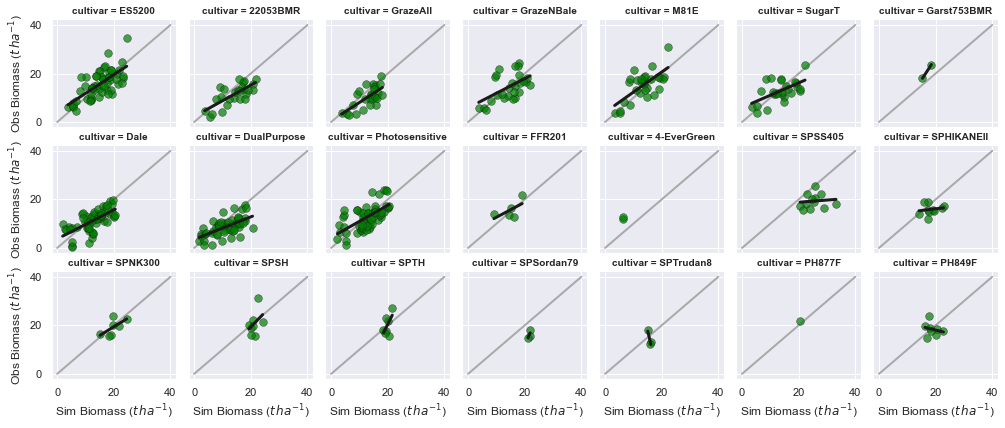

In [179]:
kwargs  =   {'edgecolor':"k"}
sns.set(font_scale=1)
g = sns.FacetGrid(final, col="cultivar", col_wrap=7, height=2)
g.map(sns.scatterplot, "sim_biomass3", "obs_biomass3", alpha=0.7, linewidth=0.5,**kwargs, s=60,zorder=2, color='green')
g.map(sns.regplot, "sim_biomass3", "obs_biomass3", ci=None, color='k', scatter=False, line_kws={'linewidth':3, "zorder":4})

xmax=40
ymax=40
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=10, fontweight="bold")
    ax.plot([0,xmax],[0,ymax],"-",color="darkgrey", linewidth=2, zorder=1)

g.fig.subplots_adjust(wspace=0.1, hspace=.18)
g.set_axis_labels("Sim Biomass ($t\,ha^{-1}$)", "Obs Biomass ($t\,ha^{-1}$)")
#g.add_legend()

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\GCBB-submission\SupplementaryMaterial-Figs\cul.png', dpi=300,bbox_inches='tight')

## Calculate summary statistics for PRE vs OBS by environment and cultivar

In [180]:
from sklearn.metrics import r2_score, mean_squared_error

def r_R2_RMSE_NSE_CCC(g):
    
    #Identify variables to compare
    x = g['sim_biomass3'] #true, observed, independent
    y = g['obs_biomass3'] #modelled, predicted, dependent
    
    ''' Pearson Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    r = sxy / (np.std(x)*np.std(y))
    
    ''' R-squared'''
    R2 = r2_score( x, y )
    
    '''Root-Mean-Square Error'''
    RMSE = np.sqrt( mean_squared_error( x, y ) )
    
    '''Normalized Nash–Sutcliffe model efficiency coefficient
    Nossent, J., & Bauwens, W. (2012, April). Application of a normalized Nash-Sutcliffe efficiency to 
    improve the accuracy of the Sobol'sensitivity analysis of a hydrological model. 
    In EGU General Assembly Conference Abstracts (p. 237).'''
    SumOfSquaredResiduals = ((np.square(y - x))).sum()
    SumOfSquaredSD = (np.square(x-(np.mean(x)))).sum()
    NSEc = (1 - SumOfSquaredResiduals / SumOfSquaredSD)
    NSE = 1 / (2 - NSEc).round(decimals=2)
    
    ''' Concordance Correlation Coefficient Lawrence, I., & Lin, K. (1989). 
    A concordance correlation coefficient to evaluate reproducibility. Biometrics, 255-268.''' 
    sxyb = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    CCC = 2*sxyb / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    
    return pd.Series(dict(r=r, R2=R2, RMSE=RMSE, NSE=NSE, CCC=CCC))

stat0 = final.groupby(['cultivar']).apply(r_R2_RMSE_NSE_CCC).reset_index()
stat = stat0.round(2)
stat
#stat.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\ccc_cultivar.csv')

<ipython-input-180-e02dd4259b69>:11: RuntimeWarning: invalid value encountered in double_scalars
  r = sxy / (np.std(x)*np.std(y))
<ipython-input-180-e02dd4259b69>:25: RuntimeWarning: divide by zero encountered in double_scalars
  NSEc = (1 - SumOfSquaredResiduals / SumOfSquaredSD)
<ipython-input-180-e02dd4259b69>:11: RuntimeWarning: invalid value encountered in double_scalars
  r = sxy / (np.std(x)*np.std(y))
C:\Users\uqjojeda\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
<ipython-input-180-e02dd4259b69>:25: RuntimeWarning: divide by zero encountered in double_scalars
  NSEc = (1 - SumOfSquaredResiduals / SumOfSquaredSD)


,cultivar,r,R2,RMSE,NSE,CCC
0,22053BMR,0.74,0.22,4.31,0.56,0.62
1,4-EverGreen,NaN,0.00,6.05,0.00,0.00
2,Dale,0.67,0.31,3.99,0.59,0.63
3,DualPurpose,0.62,0.06,4.52,0.52,0.50
4,ES5200,0.68,0.26,4.36,0.57,0.67
5,FFR201,0.61,0.14,3.02,0.54,0.59
6,Garst753BMR,1.00,-5.76,4.12,0.13,0.35
7,GrazeAll,0.69,-0.18,4.17,0.46,0.57
8,GrazeNBale,0.54,-0.05,4.95,0.49,0.53
9,M81E,0.68,0.06,4.70,0.52,0.64


In [299]:
final

,RainIn,mint_avg,RadiationIn,N_stress_expan,sw_stress_expan,maxt_avg,tp_stress,TempIn,name,year,...,cultivar,nitrogen,env,state,year2,sim_biomass3,obs_biomass3,biomassError3,biomassError,Dev
0,359.5,14.465,2352.800,1.0,0.952,25.549,0.899,20.0070,Am_IA_ES_N200_2009_Y_ALL,2009,...,ES5200,N200,Am-IA,IA,Y_ALL,19.49420,11.524800,2.0788,NaN,7.969400
1,714.3,16.740,2517.400,1.0,0.983,26.967,0.959,21.8535,Am_IA_ES_N200_2010_Y_ALL,2010,...,ES5200,N200,Am-IA,IA,Y_ALL,21.38030,15.532800,2.7548,NaN,5.847500
2,357.0,16.811,2419.400,1.0,0.850,27.697,0.940,22.2540,Am_IA_ES_N200_2011_Y_ALL,2011,...,ES5200,N200,Am-IA,IA,Y_ALL,18.80310,17.398400,2.2824,NaN,1.404700
3,222.5,17.326,2609.199,1.0,0.432,31.518,0.963,24.4220,Am_IA_ES_N200_2012_Y_ALL,2012,...,ES5200,N200,Am-IA,IA,Y_ALL,9.68230,14.922300,2.6864,NaN,-5.240000
4,359.5,14.465,2352.800,1.0,0.952,25.549,0.899,20.0070,Am_IA_G2_N200_2009_Y_ALL,2009,...,22053BMR,N200,Am-IA,IA,Y_ALL,18.21820,11.443100,1.3504,NaN,6.775100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bu_TX_00_N???_2016_Y2016,2016,...,SPNK300,N???,Bu-TX,TX,Y2016,19.68108,23.773239,NaN,NaN,-4.092159
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bu_TX_SH_N???_2016_Y2016,2016,...,SPSH,N???,Bu-TX,TX,Y2016,24.20118,21.262534,NaN,NaN,2.938646
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bu_TX_05_N???_2016_Y2016,2016,...,SPSS405,N???,Bu-TX,TX,Y2016,27.73245,22.204048,NaN,NaN,5.528402
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bu_TX_9F_N???_2017_Y2017,2017,...,PH849F,N???,Bu-TX,TX,Y2017,18.23887,17.755393,NaN,NaN,0.483477


No handles with labels found to put in legend.
No handles with labels found to put in legend.


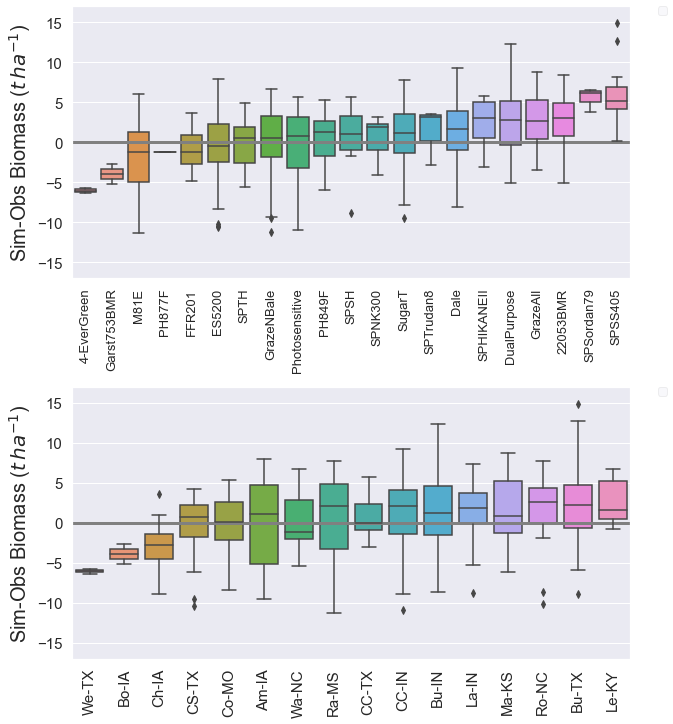

In [324]:
fig = plt.figure(figsize=(10,12))
################################################################
ax=plt.subplot(2, 1, 1)

grouped = final.groupby("cultivar")
sorted_mean = pd.DataFrame({col:vals['Dev'] for col,vals in grouped}).mean().sort_values(ascending=True)
kwargs  =   {'edgecolor':"k"}

sns.boxplot(data=final, x='cultivar', y='Dev', zorder=2, order=sorted_mean.index)
#sns.regplot(data=final000, x='TempIn', y='Dev', ci=None, color='k', scatter=False, line_kws={'linewidth':3, "zorder":4})
plt.legend(prop=dict(size=11),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
ax.axhline(y=0, color='grey', linestyle='-',  zorder=1, linewidth=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#ax.set_xlim([14,31])
ax.set_ylim([-17,17])
plt.ylabel('Sim-Obs Biomass ($t\,ha^{-1}$)', fontsize =20)
plt.xlabel('', fontsize =20)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=13)

################################################################
ax=plt.subplot(2, 1, 2)

grouped = final.groupby("env")
sorted_mean = pd.DataFrame({col:vals['Dev'] for col,vals in grouped}).mean().sort_values(ascending=True)
kwargs  =   {'edgecolor':"k"}

sns.boxplot(data=final, x='env', y='Dev', zorder=2, order=sorted_mean.index)
#sns.regplot(data=final000, x='TempIn', y='Dev', ci=None, color='k', scatter=False, line_kws={'linewidth':3, "zorder":4})
plt.legend(prop=dict(size=11),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
ax.axhline(y=0, color='grey', linestyle='-',  zorder=1, linewidth=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#ax.set_xlim([14,31])
ax.set_ylim([-17,17])
plt.ylabel('Sim-Obs Biomass ($t\,ha^{-1}$)', fontsize =20)
plt.xlabel('', fontsize =20)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

####################################################################
plt.subplots_adjust(wspace=0, hspace=0.4)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\GCBB-submission\SupplementaryMaterial-Figs\dev.png', dpi=300,bbox_inches='tight')

In [294]:
final000.columns

Index(['RainIn', 'mint_avg', 'RadiationIn', 'N_stress_expan',
       'sw_stress_expan', 'maxt_avg', 'tp_stress', 'TempIn', 'name', 'year',
       'location', 'cultivar', 'nitrogen', 'env', 'state', 'year2',
       'sim_biomass3', 'obs_biomass3', 'biomassError3', 'Dev'],
      dtype='object')

In [7]:
#final.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationData.csv')

<AxesSubplot:ylabel='Frequency'>

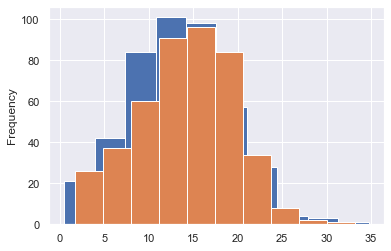

In [181]:
final.obs_biomass3.plot.hist()
final.sim_biomass3.plot.hist()

In [22]:
stat_mean = final.groupby(['env'],as_index=False).mean()
stat_sd = final.groupby(['env'],as_index=False).std()
stat_c = final.groupby(['env'],as_index=False).count()
stat_mean.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatMean.csv')
stat_sd.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatSD.csv')
stat_c.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatc.csv')